# Analyse data missingness

In [34]:
import pandas as pd
import numpy as np 
import os
from pathlib import Path
import matplotlib.pyplot as plt

In [35]:
df = pd.read_csv(f"{Path.cwd().parent.parent}/ESS/ESS_data.csv")

C:\Users\wotererio_user\AppData\Local\Temp\ipykernel_3648\3488960897.py:1: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"{Path.cwd().parent.parent}/ESS/ESS_data.csv")


In [36]:
print(df.columns)

Index(['name', 'essround', 'edition', 'proddate', 'idno', 'cntry', 'dweight',
       'pspwght', 'pweight', 'anweight', 'prob', 'stratum', 'psu', 'lrscale',
       'stfdem', 'stfeco', 'stfedu', 'stfgov', 'stfhlth', 'stflife', 'trstep',
       'trstplt', 'trstsci', 'gndr', 'age', 'agea', 'eisced', 'region',
       'regunit'],
      dtype='object')


In [69]:
# Create category corresponding to Age weight
# Define a function to categorize the 'agea' values
def categorize_age(age):
    if pd.isna(age) or age == 0:
        return 0  # Missing
    elif 15 <= age <= 34:
        return 1  # 15-34 years old
    elif 35 <= age <= 54:
        return 2  # 35-54 years old
    elif age >= 55:
        return 3  # 55+ years old
    else:
        return 0  # Default to Missing for any unexpected values
    

# Function to map the education level to a 3-point scale
def categorize_education(level):
    if level in [1, 2]:
        return 1  # Basic Education
    elif level in [3, 4]:
        return 2  # Secondary Education & Vocational Training
    elif level in [5, 6, 7]:
        return 3  # Tertiary Education
    else:
        return None  # Handle unexpected values, if any
    
def bar_plot(df):
    plt.figure(figsize=(8,6))
    ax = df.sort_index().plot(kind='bar')  # sort_index() to ensure bars are in order
    x_labels = [item.get_text() for item in ax.get_xticklabels()]
    recode_dict = {77: 'Refusal', 88: "Don't know", 99: 'No answer'}
    new_labels = [recode_dict.get(int(x), x) for x in x_labels]

    # Set the new labels on the x-axis
    ax.set_xticklabels(new_labels)

    # Redraw the chart with updated labels
    plt.draw()


    # plt.xticks(rotation=0)  # To make the x-axis labels horizontal
    # axis_labels = {77: 'Refusal', 88: "Don't know", 99: 'No answer'}
    # plt.show()




In [77]:
# Subset data for which info about education is available
## ES - ISCED = highest level of education
df = df[df.eisced < 10]
df = df[df.eisced != 0] # remove observations for which the eisced could not be harmonised 
df = df[df.essround < 11] # remove round 11, no post stratification weights available yet
df = df[df.gndr != 9] # remove people without gender
df['weight'] = df.pspwght * df.pweight

# Apply the function to create a new column 'age_group'
df['age_group'] = df['agea'].apply(categorize_age)
df = df[df.age_group != 0]

# Apply the function to create a new column with the 3-point scale
df['education_group'] = df['eisced'].apply(categorize_education)
df = df[df.education_group != 0]

df.stfgov = df.stfgov.astype(int)

variables_of_interest = ['lrscale', 'stfdem', 'stfeco', 'stfgov', 'stflife']
grouping_variables = ['cntry', 'gndr', 'age_group', 'education_group', 'essround'] # create cohorts


### Recoding missingness

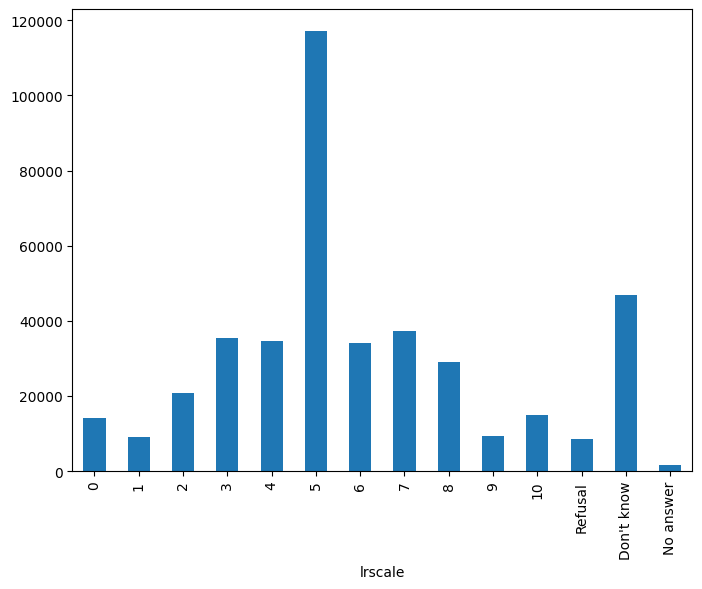

In [68]:
plt.figure(figsize=(8,6))
ax = df.lrscale.value_counts().sort_index().plot(kind='bar')
x_labels = [item.get_text() for item in ax.get_xticklabels()]

# Replace the special values (77, 88, 99) with their corresponding labels
recode_dict = {77: 'Refusal', 88: "Don't know", 99: 'No answer'}
new_labels = [recode_dict.get(int(x), x) for x in x_labels]

# Set the new labels on the x-axis
ax.set_xticklabels(new_labels)

# Redraw the chart with updated labels
plt.draw()

### Missingness in variables


- LRscale

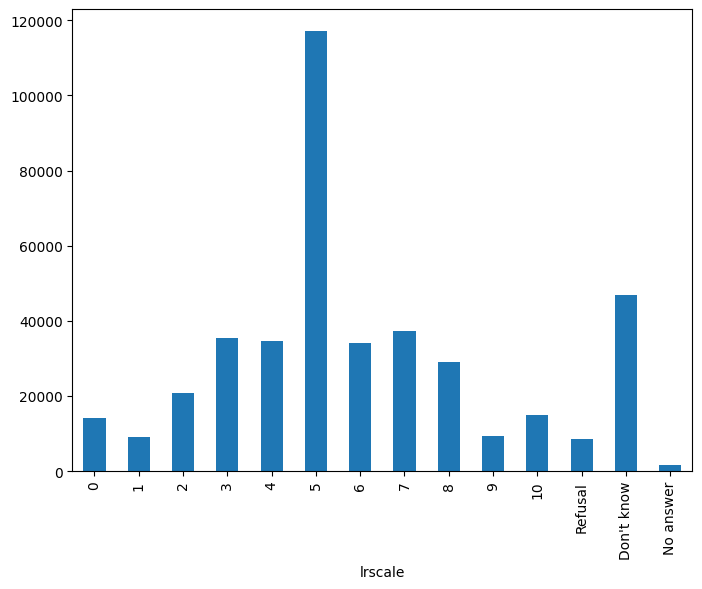

In [71]:
bar_plot(df.lrscale.value_counts())

- Satisfaction with democracy

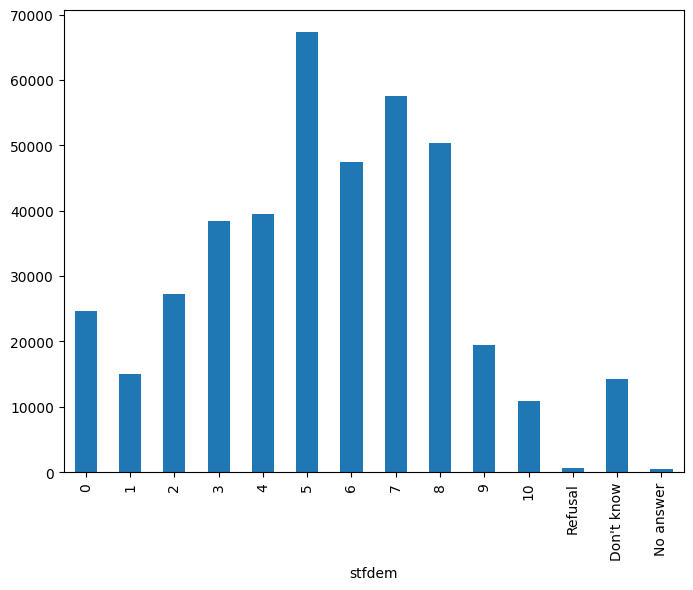

In [70]:
bar_plot(df.stfdem.value_counts())

- satisfaction with economy

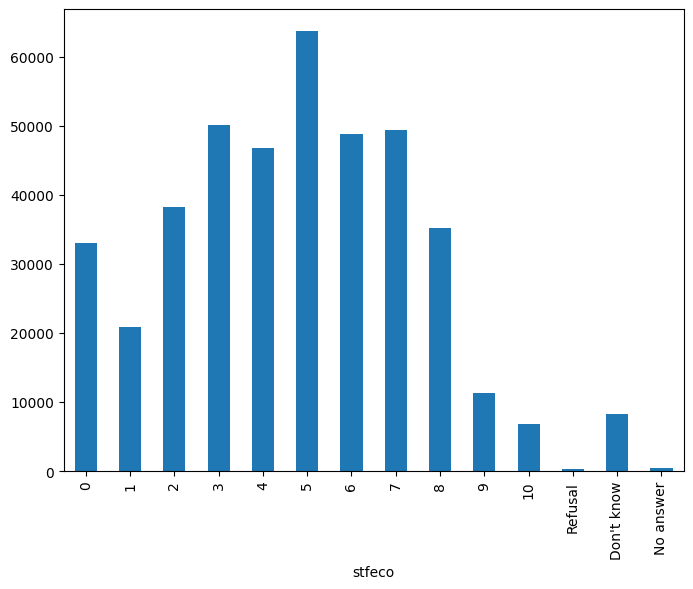

In [72]:
bar_plot(df.stfeco.value_counts())

- satisfaction with government

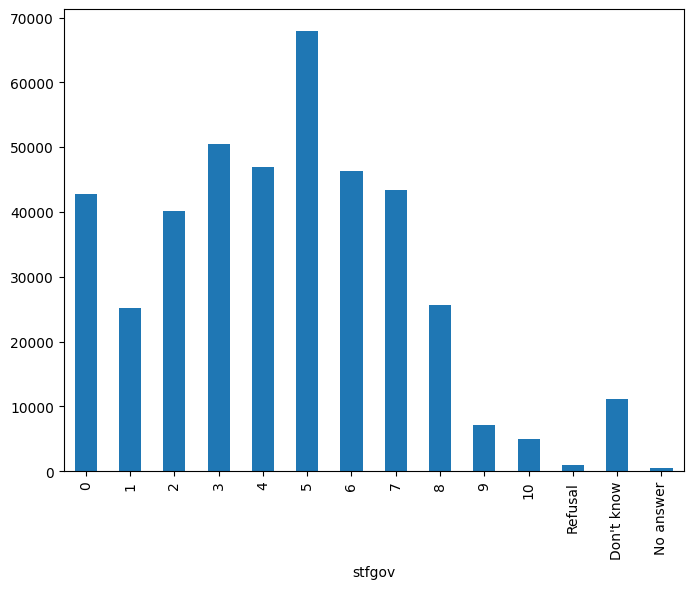

In [78]:
bar_plot(df.stfgov.value_counts())

- satisfaction with life

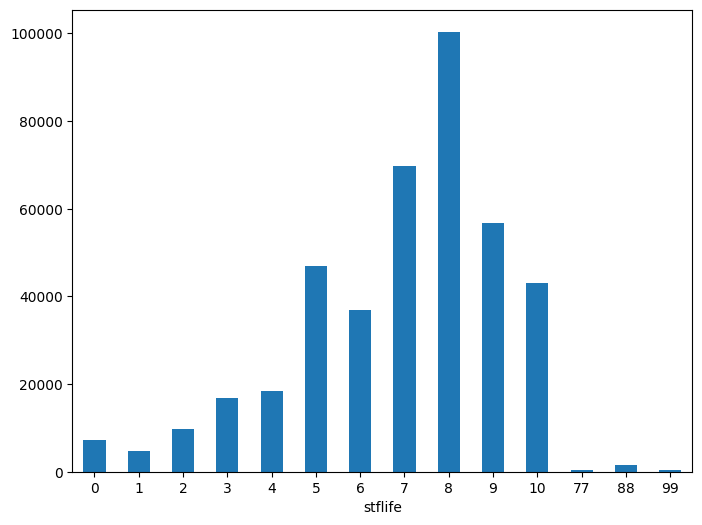

In [54]:
bar_plot(df.stflife.value_counts())

---------------

### Pseudo panel dataset
- ESS strata:
    - gender, age, education, geographical region

In [ ]:
observations_per_cohort = df.groupby(grouping_variables).size()

In [24]:
# Group by cohort as defined by post-stratification weights
grouped_df = df.groupby(grouping_variables)

In [17]:
pseudo_df = grouped_df[variables_of_interest].mean()